In [0]:
# loading in and transforming data
import os
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# visualizing data
import matplotlib.pyplot as plt
import numpy as np
import warnings

%matplotlib inline

In [2]:
# from google.colab import drive
# drive.mount('/gdrive')
# # %cd /gdrive/My\ Drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [3]:
# !ls

sample_data


In [4]:
# %cd ../../content/
# !unzip ../gdrive/My\ Drive/datasets.zip
# %cp ../gdrive/My\ Drive/helpers.py ./helpers.py

Archive:  ../gdrive/My Drive/datasets.zip
   creating: datasets/
   creating: datasets/summer2winter/
   creating: datasets/summer2winter/summer/
   creating: datasets/summer2winter/summer/1/
  inflating: datasets/summer2winter/summer/1/2014-07-01 10:31:48.jpg  
  inflating: datasets/summer2winter/summer/1/2015-07-01 23:43:46.jpg  
  inflating: datasets/summer2winter/summer/1/2014-07-27 21:50:52.jpg  
  inflating: datasets/summer2winter/summer/1/2016-09-12 21:34:08.jpg  
  inflating: datasets/summer2winter/summer/1/2015-06-10 23:35:46.jpg  
  inflating: datasets/summer2winter/summer/1/2016-07-12 13:57:26.jpg  
  inflating: datasets/summer2winter/summer/1/2014-05-13 02:35:47.jpg  
  inflating: datasets/summer2winter/summer/1/2015-07-12 20:23:26.jpg  
  inflating: datasets/summer2winter/summer/1/2015-08-26 00:23:12.jpg  
  inflating: datasets/summer2winter/summer/1/2011-05-19 11:26:37.jpg  
  inflating: datasets/summer2winter/summer/1/2014-08-12 11:31:02.jpg  
  inflating: datasets/summe

In [0]:
def get_data_loader(image_type, image_dir='./datasets/summer2winter',
                    image_size=128, batch_size=16, num_workers=3):
    
    # resize and normalize the images
    transform = transforms.Compose([transforms.Resize(image_size), # resize to 128x128
                                    transforms.ToTensor()])

    # get training and test directories
    image_path = image_dir
    train_path = os.path.join(image_path, '{}'.format(image_type))

    test_path = os.path.join(image_path, 'test_{}'.format(image_type))

    # define datasets using ImageFolder
    train_dataset = datasets.ImageFolder(train_path, transform)
    test_dataset = datasets.ImageFolder(test_path, transform)

    # create and return DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader

In [0]:
# Create train and test dataloaders for images from the two domains X and Y
# image_type = directory names for our data
dataloader_X, test_dataloader_X = get_data_loader(image_type='summer')
dataloader_Y, test_dataloader_Y = get_data_loader(image_type='winter')

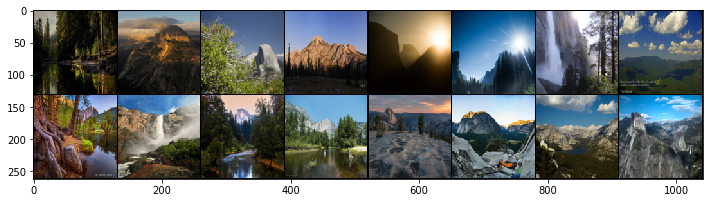

In [7]:
# helper imshow function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    

# get some images from X
dataiter = iter(dataloader_X)
# the "_" is a placeholder for no labels
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(images))

In [8]:
# current range
img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())

Min:  tensor(0.)
Max:  tensor(0.8275)


In [0]:
# helper scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    
    # scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [10]:
# scaled range
scaled_img = scale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Scaled min:  tensor(-1.)
Scaled max:  tensor(0.6549)


In [0]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [0]:
class Discriminator(nn.Module):
    
    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()

        # Define all convolutional layers
        # Should accept an RGB image as input and output a single value

        # Convolutional layers, increasing in depth
        # first layer has *no* batchnorm
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # x, y = 64, depth 64
        self.conv2 = conv(conv_dim, conv_dim*2, 4) # (32, 32, 128)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4) # (16, 16, 256)
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4) # (8, 8, 512)
        
        # Classification layer
        self.conv5 = conv(conv_dim*8, 1, 4, stride=1, batch_norm=False)

    def forward(self, x):
        # relu applied to all conv layers but last
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        out = F.relu(self.conv4(out))
        # last, classification layer
        out = self.conv5(out)
        return out

In [0]:
# residual block class
class ResidualBlock(nn.Module):
    """Defines a residual block.
       This adds an input x to a convolutional layer (applied to x) with the same size input and output.
       These blocks allow a model to learn an effective transformation from one domain to another.
    """
    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()
        # conv_dim = number of inputs
        
        # define two convolutional layers + batch normalization that will act as our residual function, F(x)
        # layers should have the same shape input as output; I suggest a kernel_size of 3
        
        self.conv_layer1 = conv(in_channels=conv_dim, out_channels=conv_dim, 
                                kernel_size=3, stride=1, padding=1, batch_norm=True)
        
        self.conv_layer2 = conv(in_channels=conv_dim, out_channels=conv_dim, 
                               kernel_size=3, stride=1, padding=1, batch_norm=True)
        
    def forward(self, x):
        # apply a ReLu activation the outputs of the first layer
        # return a summed output, x + resnet_block(x)
        out_1 = F.relu(self.conv_layer1(x))
        out_2 = x + self.conv_layer2(out_1)
        return out_2
    

In [0]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization.
    """
    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [0]:
class CycleGenerator(nn.Module):
    
    def __init__(self, conv_dim=64, n_res_blocks=6):
        super(CycleGenerator, self).__init__()

        # 1. Define the encoder part of the generator
        
        # initial convolutional layer given, below
        self.conv1 = conv(3, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)

        # 2. Define the resnet part of the generator
        # Residual blocks
        res_layers = []
        for layer in range(n_res_blocks):
            res_layers.append(ResidualBlock(conv_dim*4))
        # use sequential to create these layers
        self.res_blocks = nn.Sequential(*res_layers)

        # 3. Define the decoder part of the generator
        # two transpose convolutional layers and a third that looks a lot like the initial conv layer
        self.deconv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.deconv2 = deconv(conv_dim*2, conv_dim, 4)
        # no batch norm on last layer
        self.deconv3 = deconv(conv_dim, 3, 4, batch_norm=False)

    def forward(self, x):
        """Given an image x, returns a transformed image."""
        # define feedforward behavior, applying activations as necessary

        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))

        out = self.res_blocks(out)

        out = F.relu(self.deconv1(out))
        out = F.relu(self.deconv2(out))
        # tanh applied to last layer
        out = F.tanh(self.deconv3(out))

        return out

In [0]:
def create_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=6):
    """Builds the generators and discriminators."""
    
    # Instantiate generators
    G_XtoY = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    G_YtoX = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    # Instantiate discriminators
    D_X = Discriminator(conv_dim=d_conv_dim)
    D_Y = Discriminator(conv_dim=d_conv_dim)

    # move models to GPU, if available
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        G_XtoY.to(device)
        G_YtoX.to(device)
        D_X.to(device)
        D_Y.to(device)
        print('Models moved to GPU.')
    else:
        print('Only CPU available.')

    return G_XtoY, G_YtoX, D_X, D_Y

In [17]:
# call the function to get models
G_XtoY, G_YtoX, D_X, D_Y = create_model()

Models moved to GPU.


In [18]:
# helper function for printing the model architecture
def print_models(G_XtoY, G_YtoX, D_X, D_Y):
    """Prints model information for the generators and discriminators.
    """
    print("                     G_XtoY                    ")
    print("-----------------------------------------------")
    print(G_XtoY)
    print()

    print("                     G_YtoX                    ")
    print("-----------------------------------------------")
    print(G_YtoX)
    print()

    print("                      D_X                      ")
    print("-----------------------------------------------")
    print(D_X)
    print()

    print("                      D_Y                      ")
    print("-----------------------------------------------")
    print(D_Y)
    print()
    

# print all of the models
print_models(G_XtoY, G_YtoX, D_X, D_Y)

                     G_XtoY                    
-----------------------------------------------
CycleGenerator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (conv_layer1): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [0]:
def real_mse_loss(D_out):
    # how close is the produced output from being "real"?
    return torch.mean((D_out-1)**2)

def fake_mse_loss(D_out):
    # how close is the produced output from being "fake"?
    return torch.mean(D_out**2)

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
    # calculate reconstruction loss 
    # as absolute value difference between the real and reconstructed images
    reconstr_loss = torch.mean(torch.abs(real_im - reconstructed_im))
    # return weighted loss
    return lambda_weight*reconstr_loss    


In [0]:
import torch.optim as optim

# hyperparams for Adam optimizer
lr=0.0002
beta1=0.5
beta2=0.999 # default value

g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())  # Get generator parameters

# Create optimizers for the generators and discriminators
g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_x_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])

In [0]:
# import save code
from helpers import save_samples, checkpoint

In [0]:
# train the network

def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, 
                  n_epochs=1000):
    
    print_every=10
    
    # keep track of losses over time
    losses = []
    
    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_Y)

    # Get some fixed data from domains X and Y for sampling. These are images that are held
    # constant throughout training, that allow us to inspect the model's performance.
    fixed_X = test_iter_X.next()[0]
    fixed_Y = test_iter_Y.next()[0]
    fixed_X = scale(fixed_X) # make sure to scale to a range -1 to 1
    fixed_Y = scale(fixed_Y)

    # batches per epoch
    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)
    batches_per_epoch = min(len(iter_X), len(iter_Y))

    for epoch in range(1, n_epochs+1):

        # Reset iterators for each epoch
        if epoch % batches_per_epoch == 0:
            iter_X = iter(dataloader_X)
            iter_Y = iter(dataloader_Y)

        images_X, _ = iter_X.next()
        images_X = scale(images_X) # make sure to scale to a range -1 to 1

        images_Y, _ = iter_Y.next()
        images_Y = scale(images_Y)
        
        # move images to GPU if available (otherwise stay on CPU)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        images_X = images_X.to(device)
        images_Y = images_Y.to(device)


        # ============================================
        #            TRAIN THE DISCRIMINATORS
        # ============================================

        ##   First: D_X, real and fake loss components   ##

        # Train with real images
        d_x_optimizer.zero_grad()

        # 1. Compute the discriminator losses on real images
        out_x = D_X(images_X)
        D_X_real_loss = real_mse_loss(out_x)
        
        # Train with fake images
        
        # 2. Generate fake images that look like domain X based on real images in domain Y
        fake_X = G_YtoX(images_Y)

        # 3. Compute the fake loss for D_X
        out_x = D_X(fake_X)
        D_X_fake_loss = fake_mse_loss(out_x)
        

        # 4. Compute the total loss and perform backprop
        d_x_loss = D_X_real_loss + D_X_fake_loss
        d_x_loss.backward()
        d_x_optimizer.step()

        
        ##   Second: D_Y, real and fake loss components   ##
        
        # Train with real images
        d_y_optimizer.zero_grad()
        
        # 1. Compute the discriminator losses on real images
        out_y = D_Y(images_Y)
        D_Y_real_loss = real_mse_loss(out_y)
        
        # Train with fake images

        # 2. Generate fake images that look like domain Y based on real images in domain X
        fake_Y = G_XtoY(images_X)

        # 3. Compute the fake loss for D_Y
        out_y = D_Y(fake_Y)
        D_Y_fake_loss = fake_mse_loss(out_y)

        # 4. Compute the total loss and perform backprop
        d_y_loss = D_Y_real_loss + D_Y_fake_loss
        d_y_loss.backward()
        d_y_optimizer.step()


        # =========================================
        #            TRAIN THE GENERATORS
        # =========================================

        ##    First: generate fake X images and reconstructed Y images    ##
        g_optimizer.zero_grad()

        # 1. Generate fake images that look like domain X based on real images in domain Y
        fake_X = G_YtoX(images_Y)

        # 2. Compute the generator loss based on domain X
        out_x = D_X(fake_X)
        g_YtoX_loss = real_mse_loss(out_x)

        # 3. Create a reconstructed y
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        reconstructed_Y = G_XtoY(fake_X)
        reconstructed_y_loss = cycle_consistency_loss(images_Y, reconstructed_Y, lambda_weight=10)


        ##    Second: generate fake Y images and reconstructed X images    ##

        # 1. Generate fake images that look like domain Y based on real images in domain X
        fake_Y = G_XtoY(images_X)

        # 2. Compute the generator loss based on domain Y
        out_y = D_Y(fake_Y)
        g_XtoY_loss = real_mse_loss(out_y)

        # 3. Create a reconstructed x
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        reconstructed_X = G_YtoX(fake_Y)
        reconstructed_x_loss = cycle_consistency_loss(images_X, reconstructed_X, lambda_weight=10)

        # 5. Add up all generator and reconstructed losses and perform backprop
        g_total_loss = g_YtoX_loss + g_XtoY_loss + reconstructed_y_loss + reconstructed_x_loss
        g_total_loss.backward()
        g_optimizer.step()


        # Print the log info
        if epoch % print_every == 0:
            # append real and fake discriminator losses and the generator loss
            losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
            print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
                    epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))

            
        sample_every=100
        # Save the generated samples
        if epoch % sample_every == 0:
            G_YtoX.eval() # set generators to eval mode for sample generation
            G_XtoY.eval()
            save_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16, sample_dir='samples_cyclegan')
            G_YtoX.train()
            G_XtoY.train()

        # uncomment these lines, if you want to save your model
#         checkpoint_every=1000
#         # Save the model parameters
#         if epoch % checkpoint_every == 0:
#             checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y)

    return losses


In [0]:
n_epochs = 4000 # keep this small when testing if a model first works

losses = training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs=n_epochs)

Epoch [   10/ 4000] | d_X_loss: 0.5374 | d_Y_loss: 0.3283 | g_total_loss: 8.8618
Epoch [   20/ 4000] | d_X_loss: 0.4377 | d_Y_loss: 0.4681 | g_total_loss: 7.4537
Epoch [   30/ 4000] | d_X_loss: 0.5048 | d_Y_loss: 1.4776 | g_total_loss: 5.6259
Epoch [   40/ 4000] | d_X_loss: 0.3554 | d_Y_loss: 0.5161 | g_total_loss: 5.5941
Epoch [   50/ 4000] | d_X_loss: 0.2519 | d_Y_loss: 1.1015 | g_total_loss: 6.0190
Epoch [   60/ 4000] | d_X_loss: 0.3353 | d_Y_loss: 0.4876 | g_total_loss: 5.9535
Epoch [   70/ 4000] | d_X_loss: 0.4511 | d_Y_loss: 0.3532 | g_total_loss: 4.9781
Epoch [   80/ 4000] | d_X_loss: 0.4934 | d_Y_loss: 0.6474 | g_total_loss: 6.0766
Epoch [   90/ 4000] | d_X_loss: 0.4615 | d_Y_loss: 0.5789 | g_total_loss: 5.5904


Epoch [  100/ 4000] | d_X_loss: 0.4038 | d_Y_loss: 0.5245 | g_total_loss: 5.3150


Saved samples_cyclegan/sample-000100-X-Y.png
Saved samples_cyclegan/sample-000100-Y-X.png
Epoch [  110/ 4000] | d_X_loss: 0.3827 | d_Y_loss: 0.2939 | g_total_loss: 5.6142
Epoch [  120/ 4000] | d_X_loss: 0.4500 | d_Y_loss: 0.3368 | g_total_loss: 4.5958
Epoch [  130/ 4000] | d_X_loss: 0.4716 | d_Y_loss: 0.4357 | g_total_loss: 4.7323
Epoch [  140/ 4000] | d_X_loss: 0.5596 | d_Y_loss: 0.3808 | g_total_loss: 4.7787
Epoch [  150/ 4000] | d_X_loss: 0.4158 | d_Y_loss: 0.4718 | g_total_loss: 4.3689
Epoch [  160/ 4000] | d_X_loss: 0.3593 | d_Y_loss: 0.2460 | g_total_loss: 4.5395
Epoch [  170/ 4000] | d_X_loss: 0.3323 | d_Y_loss: 0.5691 | g_total_loss: 4.5415
Epoch [  180/ 4000] | d_X_loss: 0.4246 | d_Y_loss: 0.9715 | g_total_loss: 4.3730
Epoch [  190/ 4000] | d_X_loss: 0.6494 | d_Y_loss: 0.5726 | g_total_loss: 5.5169


Epoch [  200/ 4000] | d_X_loss: 0.4334 | d_Y_loss: 0.4653 | g_total_loss: 4.5776


Saved samples_cyclegan/sample-000200-X-Y.png
Saved samples_cyclegan/sample-000200-Y-X.png
Epoch [  210/ 4000] | d_X_loss: 0.3699 | d_Y_loss: 0.4109 | g_total_loss: 4.9678
Epoch [  220/ 4000] | d_X_loss: 0.4952 | d_Y_loss: 0.5290 | g_total_loss: 4.4778
Epoch [  230/ 4000] | d_X_loss: 0.5338 | d_Y_loss: 0.3497 | g_total_loss: 4.1602
Epoch [  240/ 4000] | d_X_loss: 0.5396 | d_Y_loss: 0.4829 | g_total_loss: 5.5145
Epoch [  250/ 4000] | d_X_loss: 0.9175 | d_Y_loss: 0.5978 | g_total_loss: 3.8767
Epoch [  260/ 4000] | d_X_loss: 0.2687 | d_Y_loss: 0.5866 | g_total_loss: 4.2492
Epoch [  270/ 4000] | d_X_loss: 0.6599 | d_Y_loss: 0.4734 | g_total_loss: 5.3365
Epoch [  280/ 4000] | d_X_loss: 0.3387 | d_Y_loss: 0.2550 | g_total_loss: 5.1676
Epoch [  290/ 4000] | d_X_loss: 0.4363 | d_Y_loss: 0.2579 | g_total_loss: 5.4970


Epoch [  300/ 4000] | d_X_loss: 0.3163 | d_Y_loss: 0.3556 | g_total_loss: 5.2998


Saved samples_cyclegan/sample-000300-X-Y.png
Saved samples_cyclegan/sample-000300-Y-X.png
Epoch [  310/ 4000] | d_X_loss: 0.3251 | d_Y_loss: 0.6102 | g_total_loss: 4.0407
Epoch [  320/ 4000] | d_X_loss: 0.2644 | d_Y_loss: 0.4464 | g_total_loss: 4.9301
Epoch [  330/ 4000] | d_X_loss: 0.4068 | d_Y_loss: 0.8758 | g_total_loss: 4.6051
Epoch [  340/ 4000] | d_X_loss: 0.4115 | d_Y_loss: 0.4074 | g_total_loss: 4.0860
Epoch [  350/ 4000] | d_X_loss: 0.4025 | d_Y_loss: 0.4932 | g_total_loss: 4.3848
Epoch [  360/ 4000] | d_X_loss: 0.4332 | d_Y_loss: 0.3606 | g_total_loss: 5.1874
Epoch [  370/ 4000] | d_X_loss: 0.3771 | d_Y_loss: 0.1921 | g_total_loss: 5.6561
Epoch [  380/ 4000] | d_X_loss: 0.4416 | d_Y_loss: 0.5419 | g_total_loss: 4.8468
Epoch [  390/ 4000] | d_X_loss: 0.3752 | d_Y_loss: 0.4375 | g_total_loss: 4.3060


Epoch [  400/ 4000] | d_X_loss: 0.3693 | d_Y_loss: 0.2561 | g_total_loss: 4.7423


Saved samples_cyclegan/sample-000400-X-Y.png
Saved samples_cyclegan/sample-000400-Y-X.png
Epoch [  410/ 4000] | d_X_loss: 0.4479 | d_Y_loss: 0.3164 | g_total_loss: 4.3646
Epoch [  420/ 4000] | d_X_loss: 0.3422 | d_Y_loss: 0.4040 | g_total_loss: 3.7090
Epoch [  430/ 4000] | d_X_loss: 0.4047 | d_Y_loss: 0.3883 | g_total_loss: 4.9322
Epoch [  440/ 4000] | d_X_loss: 0.4455 | d_Y_loss: 0.4621 | g_total_loss: 4.2824
Epoch [  450/ 4000] | d_X_loss: 0.3518 | d_Y_loss: 0.2756 | g_total_loss: 4.6800
Epoch [  460/ 4000] | d_X_loss: 0.3756 | d_Y_loss: 0.3730 | g_total_loss: 4.1321
Epoch [  470/ 4000] | d_X_loss: 0.4866 | d_Y_loss: 0.3182 | g_total_loss: 4.1790
Epoch [  480/ 4000] | d_X_loss: 0.5185 | d_Y_loss: 0.4060 | g_total_loss: 3.5914
Epoch [  490/ 4000] | d_X_loss: 0.2821 | d_Y_loss: 0.3739 | g_total_loss: 4.7353


Epoch [  500/ 4000] | d_X_loss: 0.3243 | d_Y_loss: 0.3409 | g_total_loss: 4.2080


Saved samples_cyclegan/sample-000500-X-Y.png
Saved samples_cyclegan/sample-000500-Y-X.png
Epoch [  510/ 4000] | d_X_loss: 0.3374 | d_Y_loss: 0.3406 | g_total_loss: 3.8996
Epoch [  520/ 4000] | d_X_loss: 0.3559 | d_Y_loss: 0.2865 | g_total_loss: 4.1111
Epoch [  530/ 4000] | d_X_loss: 0.3759 | d_Y_loss: 0.3920 | g_total_loss: 3.8264
Epoch [  540/ 4000] | d_X_loss: 0.3644 | d_Y_loss: 0.3400 | g_total_loss: 4.4751
Epoch [  550/ 4000] | d_X_loss: 0.2842 | d_Y_loss: 0.2805 | g_total_loss: 4.4487
Epoch [  560/ 4000] | d_X_loss: 0.2795 | d_Y_loss: 0.4023 | g_total_loss: 4.0429
Epoch [  570/ 4000] | d_X_loss: 0.3751 | d_Y_loss: 0.3388 | g_total_loss: 4.6162
Epoch [  580/ 4000] | d_X_loss: 0.4034 | d_Y_loss: 0.3752 | g_total_loss: 4.1489
Epoch [  590/ 4000] | d_X_loss: 0.3556 | d_Y_loss: 0.4663 | g_total_loss: 3.8613


Epoch [  600/ 4000] | d_X_loss: 0.3707 | d_Y_loss: 0.4934 | g_total_loss: 4.3828


Saved samples_cyclegan/sample-000600-X-Y.png
Saved samples_cyclegan/sample-000600-Y-X.png
Epoch [  610/ 4000] | d_X_loss: 0.5476 | d_Y_loss: 0.3535 | g_total_loss: 4.4379
Epoch [  620/ 4000] | d_X_loss: 0.3555 | d_Y_loss: 0.3324 | g_total_loss: 4.0269
Epoch [  630/ 4000] | d_X_loss: 0.3144 | d_Y_loss: 0.3994 | g_total_loss: 3.6463
Epoch [  640/ 4000] | d_X_loss: 0.6352 | d_Y_loss: 0.3679 | g_total_loss: 3.4443
Epoch [  650/ 4000] | d_X_loss: 0.4573 | d_Y_loss: 0.2847 | g_total_loss: 3.9776
Epoch [  660/ 4000] | d_X_loss: 0.5173 | d_Y_loss: 0.3675 | g_total_loss: 3.4708
Epoch [  670/ 4000] | d_X_loss: 0.7460 | d_Y_loss: 0.6800 | g_total_loss: 5.6371
Epoch [  680/ 4000] | d_X_loss: 0.3861 | d_Y_loss: 0.3571 | g_total_loss: 3.9591
Epoch [  690/ 4000] | d_X_loss: 0.4547 | d_Y_loss: 0.6419 | g_total_loss: 3.0542


Epoch [  700/ 4000] | d_X_loss: 0.5603 | d_Y_loss: 0.3655 | g_total_loss: 3.4220


Saved samples_cyclegan/sample-000700-X-Y.png
Saved samples_cyclegan/sample-000700-Y-X.png
Epoch [  710/ 4000] | d_X_loss: 0.4457 | d_Y_loss: 0.4591 | g_total_loss: 4.0444
Epoch [  720/ 4000] | d_X_loss: 0.3990 | d_Y_loss: 0.3825 | g_total_loss: 4.0881
Epoch [  730/ 4000] | d_X_loss: 0.3177 | d_Y_loss: 0.4870 | g_total_loss: 5.0771
Epoch [  740/ 4000] | d_X_loss: 0.3200 | d_Y_loss: 0.4078 | g_total_loss: 3.8111
Epoch [  750/ 4000] | d_X_loss: 0.3325 | d_Y_loss: 0.5547 | g_total_loss: 4.6605
Epoch [  760/ 4000] | d_X_loss: 0.3518 | d_Y_loss: 0.2981 | g_total_loss: 3.8992
Epoch [  770/ 4000] | d_X_loss: 0.3157 | d_Y_loss: 0.4990 | g_total_loss: 3.4454
Epoch [  780/ 4000] | d_X_loss: 0.4841 | d_Y_loss: 0.3907 | g_total_loss: 3.9057
Epoch [  790/ 4000] | d_X_loss: 0.3524 | d_Y_loss: 0.3133 | g_total_loss: 3.7840


Epoch [  800/ 4000] | d_X_loss: 0.3446 | d_Y_loss: 0.3774 | g_total_loss: 4.4006


Saved samples_cyclegan/sample-000800-X-Y.png
Saved samples_cyclegan/sample-000800-Y-X.png
Epoch [  810/ 4000] | d_X_loss: 0.3791 | d_Y_loss: 0.3663 | g_total_loss: 3.9474
Epoch [  820/ 4000] | d_X_loss: 0.3913 | d_Y_loss: 0.3546 | g_total_loss: 3.7363
Epoch [  830/ 4000] | d_X_loss: 0.4239 | d_Y_loss: 0.4607 | g_total_loss: 3.7682
Epoch [  840/ 4000] | d_X_loss: 0.6537 | d_Y_loss: 0.3909 | g_total_loss: 3.4387
Epoch [  850/ 4000] | d_X_loss: 0.3280 | d_Y_loss: 0.4218 | g_total_loss: 3.4558
Epoch [  860/ 4000] | d_X_loss: 0.3607 | d_Y_loss: 0.3497 | g_total_loss: 4.3204
Epoch [  870/ 4000] | d_X_loss: 0.4309 | d_Y_loss: 0.4132 | g_total_loss: 4.4596
Epoch [  880/ 4000] | d_X_loss: 0.3945 | d_Y_loss: 0.2881 | g_total_loss: 4.0562
Epoch [  890/ 4000] | d_X_loss: 0.3164 | d_Y_loss: 0.4279 | g_total_loss: 4.0658


Epoch [  900/ 4000] | d_X_loss: 0.4074 | d_Y_loss: 0.3998 | g_total_loss: 4.0281


Saved samples_cyclegan/sample-000900-X-Y.png
Saved samples_cyclegan/sample-000900-Y-X.png
Epoch [  910/ 4000] | d_X_loss: 0.4274 | d_Y_loss: 0.3761 | g_total_loss: 3.8260
Epoch [  920/ 4000] | d_X_loss: 0.2595 | d_Y_loss: 0.4568 | g_total_loss: 4.2049
Epoch [  930/ 4000] | d_X_loss: 0.2663 | d_Y_loss: 0.3868 | g_total_loss: 4.6095
Epoch [  940/ 4000] | d_X_loss: 0.2112 | d_Y_loss: 0.3300 | g_total_loss: 4.2704
Epoch [  950/ 4000] | d_X_loss: 0.3151 | d_Y_loss: 0.5094 | g_total_loss: 3.4896
Epoch [  960/ 4000] | d_X_loss: 0.3853 | d_Y_loss: 0.4489 | g_total_loss: 3.6105
Epoch [  970/ 4000] | d_X_loss: 0.4615 | d_Y_loss: 0.3376 | g_total_loss: 3.8871
Epoch [  980/ 4000] | d_X_loss: 0.5840 | d_Y_loss: 0.4124 | g_total_loss: 4.1957
Epoch [  990/ 4000] | d_X_loss: 0.2052 | d_Y_loss: 0.3340 | g_total_loss: 4.6031


Epoch [ 1000/ 4000] | d_X_loss: 0.3724 | d_Y_loss: 0.5828 | g_total_loss: 4.6416


Saved samples_cyclegan/sample-001000-X-Y.png
Saved samples_cyclegan/sample-001000-Y-X.png
Epoch [ 1010/ 4000] | d_X_loss: 0.4268 | d_Y_loss: 0.4203 | g_total_loss: 4.5519
Epoch [ 1020/ 4000] | d_X_loss: 0.2472 | d_Y_loss: 0.3681 | g_total_loss: 4.8528
Epoch [ 1030/ 4000] | d_X_loss: 0.4273 | d_Y_loss: 0.6996 | g_total_loss: 4.3609
Epoch [ 1040/ 4000] | d_X_loss: 0.3055 | d_Y_loss: 0.3071 | g_total_loss: 3.9031
Epoch [ 1050/ 4000] | d_X_loss: 0.2845 | d_Y_loss: 0.3354 | g_total_loss: 3.9756
Epoch [ 1060/ 4000] | d_X_loss: 0.2966 | d_Y_loss: 0.4660 | g_total_loss: 5.4701
Epoch [ 1070/ 4000] | d_X_loss: 0.5808 | d_Y_loss: 0.2526 | g_total_loss: 4.2369
Epoch [ 1080/ 4000] | d_X_loss: 0.2308 | d_Y_loss: 0.6385 | g_total_loss: 4.1615
Epoch [ 1090/ 4000] | d_X_loss: 0.4674 | d_Y_loss: 0.3355 | g_total_loss: 3.3772


Epoch [ 1100/ 4000] | d_X_loss: 0.3769 | d_Y_loss: 0.6337 | g_total_loss: 4.8259


Saved samples_cyclegan/sample-001100-X-Y.png
Saved samples_cyclegan/sample-001100-Y-X.png
Epoch [ 1110/ 4000] | d_X_loss: 0.3411 | d_Y_loss: 0.3818 | g_total_loss: 3.6545
Epoch [ 1120/ 4000] | d_X_loss: 0.6463 | d_Y_loss: 0.2802 | g_total_loss: 3.5811
Epoch [ 1130/ 4000] | d_X_loss: 0.3143 | d_Y_loss: 0.4618 | g_total_loss: 4.2188
Epoch [ 1140/ 4000] | d_X_loss: 0.4719 | d_Y_loss: 0.4256 | g_total_loss: 4.1919
Epoch [ 1150/ 4000] | d_X_loss: 0.4278 | d_Y_loss: 0.4068 | g_total_loss: 3.9771
Epoch [ 1160/ 4000] | d_X_loss: 0.2731 | d_Y_loss: 0.2625 | g_total_loss: 3.8210
Epoch [ 1170/ 4000] | d_X_loss: 0.3170 | d_Y_loss: 0.3392 | g_total_loss: 3.4592
Epoch [ 1180/ 4000] | d_X_loss: 0.5281 | d_Y_loss: 0.4736 | g_total_loss: 3.4503
Epoch [ 1190/ 4000] | d_X_loss: 0.2266 | d_Y_loss: 0.3372 | g_total_loss: 3.8760


Epoch [ 1200/ 4000] | d_X_loss: 0.3325 | d_Y_loss: 0.2597 | g_total_loss: 3.9534


Saved samples_cyclegan/sample-001200-X-Y.png
Saved samples_cyclegan/sample-001200-Y-X.png
Epoch [ 1210/ 4000] | d_X_loss: 0.3477 | d_Y_loss: 0.4259 | g_total_loss: 4.4219
Epoch [ 1220/ 4000] | d_X_loss: 0.3874 | d_Y_loss: 0.5490 | g_total_loss: 3.5531
Epoch [ 1230/ 4000] | d_X_loss: 0.2399 | d_Y_loss: 0.3714 | g_total_loss: 4.2261
Epoch [ 1240/ 4000] | d_X_loss: 0.1676 | d_Y_loss: 0.3084 | g_total_loss: 4.2347
Epoch [ 1250/ 4000] | d_X_loss: 0.6324 | d_Y_loss: 0.2786 | g_total_loss: 4.2467
Epoch [ 1260/ 4000] | d_X_loss: 0.3132 | d_Y_loss: 0.2723 | g_total_loss: 3.2047
Epoch [ 1270/ 4000] | d_X_loss: 0.2539 | d_Y_loss: 0.2930 | g_total_loss: 4.0807
Epoch [ 1280/ 4000] | d_X_loss: 0.4027 | d_Y_loss: 0.5933 | g_total_loss: 5.0331
Epoch [ 1290/ 4000] | d_X_loss: 0.2525 | d_Y_loss: 0.3174 | g_total_loss: 3.7103


Epoch [ 1300/ 4000] | d_X_loss: 0.3181 | d_Y_loss: 0.2879 | g_total_loss: 4.7293


Saved samples_cyclegan/sample-001300-X-Y.png
Saved samples_cyclegan/sample-001300-Y-X.png
Epoch [ 1310/ 4000] | d_X_loss: 0.2408 | d_Y_loss: 0.2370 | g_total_loss: 4.5745
Epoch [ 1320/ 4000] | d_X_loss: 0.3691 | d_Y_loss: 0.3534 | g_total_loss: 3.7067
Epoch [ 1330/ 4000] | d_X_loss: 0.2882 | d_Y_loss: 0.3514 | g_total_loss: 4.2326
Epoch [ 1340/ 4000] | d_X_loss: 0.3237 | d_Y_loss: 0.3225 | g_total_loss: 3.6795
Epoch [ 1350/ 4000] | d_X_loss: 0.8659 | d_Y_loss: 0.3419 | g_total_loss: 3.5056
Epoch [ 1360/ 4000] | d_X_loss: 0.1950 | d_Y_loss: 0.2948 | g_total_loss: 4.3437
Epoch [ 1370/ 4000] | d_X_loss: 0.2193 | d_Y_loss: 0.3285 | g_total_loss: 3.8290
Epoch [ 1380/ 4000] | d_X_loss: 0.1623 | d_Y_loss: 0.3336 | g_total_loss: 4.3278
Epoch [ 1390/ 4000] | d_X_loss: 0.4602 | d_Y_loss: 0.4984 | g_total_loss: 4.0185


Epoch [ 1400/ 4000] | d_X_loss: 0.1549 | d_Y_loss: 0.3702 | g_total_loss: 4.4518


Saved samples_cyclegan/sample-001400-X-Y.png
Saved samples_cyclegan/sample-001400-Y-X.png
Epoch [ 1410/ 4000] | d_X_loss: 0.3505 | d_Y_loss: 0.3737 | g_total_loss: 5.1512
Epoch [ 1420/ 4000] | d_X_loss: 0.1372 | d_Y_loss: 0.6298 | g_total_loss: 3.4126
Epoch [ 1430/ 4000] | d_X_loss: 0.2963 | d_Y_loss: 0.2959 | g_total_loss: 3.6105
Epoch [ 1440/ 4000] | d_X_loss: 0.1396 | d_Y_loss: 0.3319 | g_total_loss: 4.3181
Epoch [ 1450/ 4000] | d_X_loss: 0.1563 | d_Y_loss: 0.6957 | g_total_loss: 4.5751
Epoch [ 1460/ 4000] | d_X_loss: 0.1804 | d_Y_loss: 0.2925 | g_total_loss: 3.9729
Epoch [ 1470/ 4000] | d_X_loss: 0.1547 | d_Y_loss: 0.2246 | g_total_loss: 4.3273
Epoch [ 1480/ 4000] | d_X_loss: 0.0548 | d_Y_loss: 0.3151 | g_total_loss: 3.8251
Epoch [ 1490/ 4000] | d_X_loss: 0.1248 | d_Y_loss: 0.2539 | g_total_loss: 4.2533


Epoch [ 1500/ 4000] | d_X_loss: 0.3787 | d_Y_loss: 0.4078 | g_total_loss: 3.6872


Saved samples_cyclegan/sample-001500-X-Y.png
Saved samples_cyclegan/sample-001500-Y-X.png
Epoch [ 1510/ 4000] | d_X_loss: 0.1701 | d_Y_loss: 0.2790 | g_total_loss: 4.1788
Epoch [ 1520/ 4000] | d_X_loss: 0.2642 | d_Y_loss: 0.3769 | g_total_loss: 3.6755


In [0]:
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator, X', alpha=0.5)
plt.plot(losses.T[1], label='Discriminator, Y', alpha=0.5)
plt.plot(losses.T[2], label='Generators', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [0]:
import matplotlib.image as mpimg

# helper visualization code
def view_samples(iteration, sample_dir='samples_cyclegan'):
    
    # samples are named by iteration
    path_XtoY = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    path_YtoX = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    
    # read in those samples
    try: 
        x2y = mpimg.imread(path_XtoY)
        y2x = mpimg.imread(path_YtoX)
    except:
        print('Invalid number of iterations.')
    
    fig, (ax1, ax2) = plt.subplots(figsize=(18,20), nrows=2, ncols=1, sharey=True, sharex=True)
    ax1.imshow(x2y)
    ax1.set_title('X to Y')
    ax2.imshow(y2x)
    ax2.set_title('Y to X')

In [0]:
# view samples at iteration 4000
view_samples(4000, 'samples_cyclegan')